# TODO

- [ ] Remove outliers
- [ ] Categorical -> Numerical
- [ ] Display information about the variables such as correlation between age~stroke, age,sex,bmi etc
- [ ] Justify why imputation is done on 'age', 'sex' instead of using a KNNImputer.
- [ ] Run SVM and NN on the dataset without resampling
- [ ] Resample using SMOTE

## Interesting analysis

- https://www.kaggle.com/joshuaswords/predicting-a-stroke-shap-lime-explainer-eli5
- https://www.kaggle.com/rachidyz/eda-and-modeling-for-predicting-stroke

# Stroke prediction

The goal of this model is to predict if a person is going to suffer a stroke.

Since false negative are more important (false positives can be checked at the hospital), we are going to add more weight on those in the loss function. 

Do not use precision as the score since the dataset is imbalanced. Use F1-score instead.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
cmap = sns.cm.mako_r

%matplotlib inline

In [2]:
from sklearn.utils import check_random_state
np.random.seed(666)
assert check_random_state is not None, "Set numpy seed for determinism."

## Introduction

In [3]:
df = pd.read_csv('../dataset/stroke.csv').drop(columns=['id'])

In [4]:
df.shape

(5110, 11)

In [5]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
categorical_cols = df.select_dtypes(include=object).columns
binary_cols = ['stroke', 'hypertension', 'heart_disease']
numerical_cols = df.select_dtypes(include=np.number).columns.drop(binary_cols)
print(f'Numerical variables: {len(numerical_cols)}')
print(f'Binary variables: {len(binary_cols)}')
print(f'Categorical variables: {len(categorical_cols)}')

Numerical variables: 3
Binary variables: 3
Categorical variables: 5


In [7]:
df[numerical_cols].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


**The dataset is imbalanced**

No stroke 4861, Stroke 249


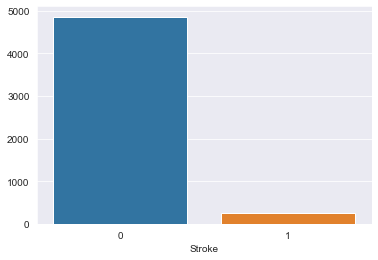

In [8]:
xs = df['stroke'].value_counts().index
ys = df['stroke'].value_counts().values

print(f"No stroke {ys[0]}, Stroke {ys[1]}")

ax = sns.barplot(x=xs, y=ys)
ax.set_xlabel("Stroke")
plt.show()

/usr/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>,
        <AxesSubplot:title={'center':'bmi'}>]], dtype=object)

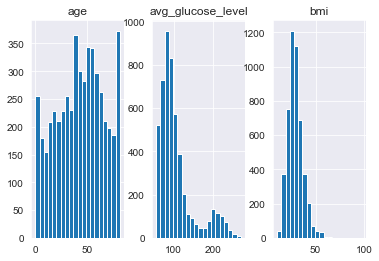

In [9]:
df[numerical_cols].hist(bins=20, layout=(1,3))

In [10]:
df[df['gender'] == 'Other'].shape[0]

# There is only one person with 'Other' gender so we will
# consider it an outlier .
df = df[df['gender'] != 'Other']

See if the categories are balanced

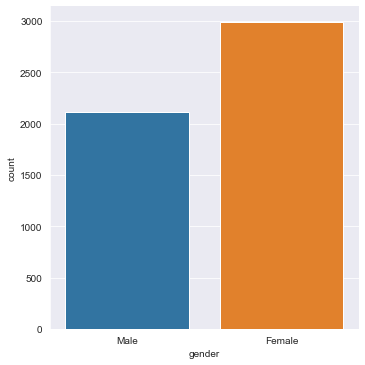

In [11]:
sns.catplot(x='gender', kind='count', data=df)

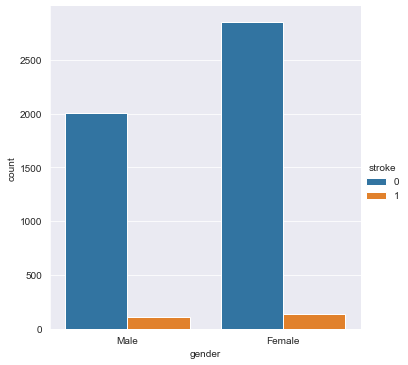

In [12]:
sns.catplot(x='gender', hue='stroke', kind='count', data=df)

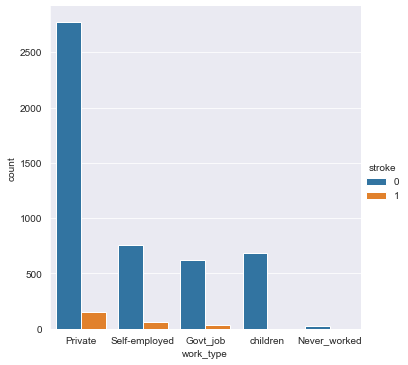

In [13]:
sns.catplot(x="work_type", hue="stroke", kind="count", data=df)

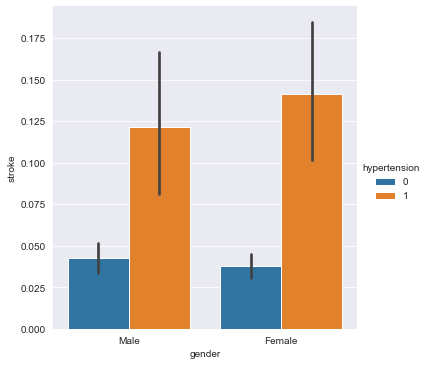

In [14]:
sns.catplot(x="gender", y="stroke", hue="hypertension", kind="bar", data=df)

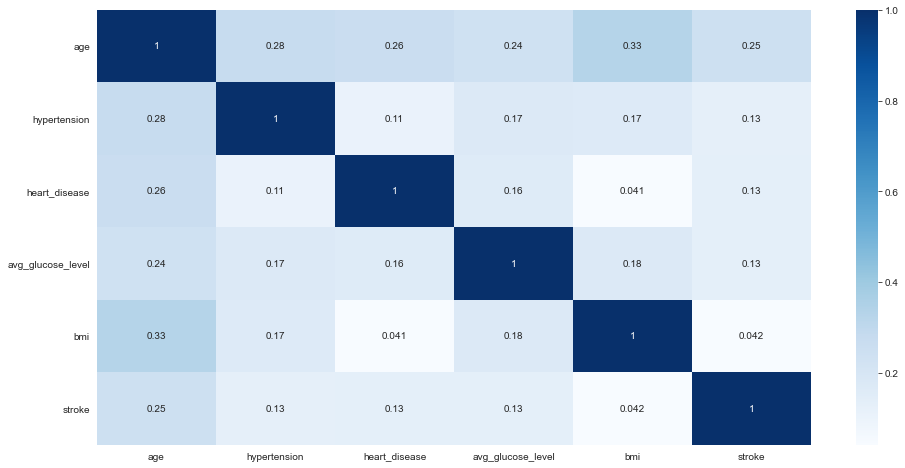

In [15]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),cmap="Blues", annot=True);

## Preprocessing

### Imputation

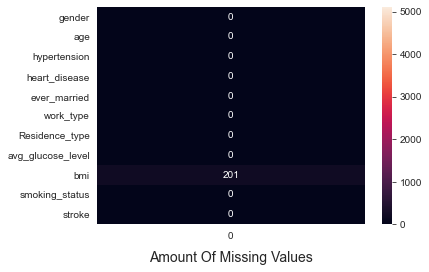

In [16]:
def displayMissingValues():
    plt.title('Amount Of Missing Values',fontsize=14, y=-0.2)
    ax = sns.heatmap(pd.DataFrame(df.isna().sum()),annot=True, fmt='d', vmin=0, vmax=df.shape[0])
displayMissingValues()

A naive imputation such as the *mean of all non missing bmi* will not work since 'bmi' depends on other variables e.g. 'age', 'gender', etc.

```python
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

X = np.array(df.bmi).reshape(-1,1)
df.bmi = imp_mean.fit_transform(X)
```

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

imp_dt = DecisionTreeRegressor(random_state=42)

pipe = \
  Pipeline(steps=[('scale',StandardScaler()), 
                  ('imputer', imp_dt)])

X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
pipe.fit(X,Y)
predicted_bmi = pd.Series(pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

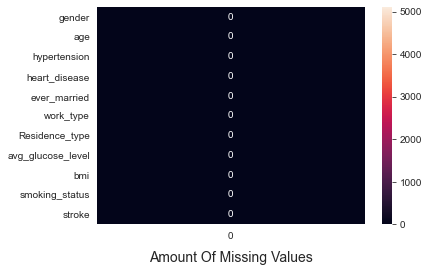

In [18]:
displayMissingValues()

### Dealing with outliers

### Categorical to numerical

## Naive classification without resampling

## SMOTE: Resampling